In [1]:
import torch
v = torch.randn((3,4,4), requires_grad=True)

In [2]:
v

tensor([[[ 0.2207, -0.1328, -0.7798, -2.3555],
         [-1.2998, -0.5394,  0.8199, -0.2016],
         [ 0.5540, -0.9982,  0.2561,  0.4426],
         [ 0.5891, -0.8276, -0.7395, -0.2974]],

        [[-0.4971, -0.2347,  1.8476,  0.6265],
         [-1.3597,  1.6430, -0.2241,  0.9372],
         [ 1.5254, -0.0621,  1.4060,  0.0361],
         [ 0.9511, -0.2241,  0.9119,  0.8142]],

        [[ 0.5490, -0.0291,  1.3689, -0.1221],
         [-0.1655, -2.0173, -1.1093,  0.1035],
         [ 0.3271, -0.0411, -0.6908, -0.7499],
         [-0.9551,  1.9407, -0.7649, -0.9536]]], requires_grad=True)

In [53]:
input_var = torch.tensor(3., requires_grad=True)


In [6]:
input_var

tensor(3., requires_grad=True)

In [54]:
y = input_var**2
y.backward()
input_var.grad

tensor(6.)

gradient for constant

In [57]:
input_const = torch.tensor(3.)
input_const = input_const.requires_grad_()
y = input_const**2
y.backward()
input_const.grad

tensor(6.)

## AN END-TO-END EXAMPLE: A LINEAR CLASSIFIER

In [2]:
import numpy as np
import torch

n = 1000
neg = np.random.multivariate_normal([0,3], [[1,0.5],[0.5,1]], size=n)
pos = np.random.multivariate_normal([3,0], [[1,0.5],[0.5,1]], size=n)

X_np =  np.vstack([neg,pos]).astype(np.float32)
y_np = np.vstack([np.zeros((n,1), np.float32),
                  np.ones((n,1), np.float32)])

In [3]:
X = torch.from_numpy(X_np)
y = torch.from_numpy(y_np)

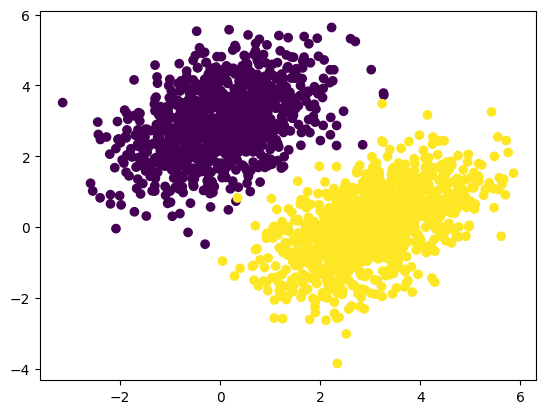

In [4]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y[:,0])
plt.show()

Now let's create a linear classifier that can learn to separate these two blobs.

**CREATEING THE LINEAR CLASSIFIER VARIABLES**

In [5]:
input_dim = 2
output_dim = 1
#====Parameters====
W = torch.nn.Parameter(torch.rand(2,1)) #trainable by default
b = torch.nn.Parameter(torch.zeros(1))

**THE FORWARD PASS FUNCTION**

In [6]:
def model(x):
    return x @ W + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients,
w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. As such,
for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x,
y] + b = w1 * x + w2 * y + b.
The following listing shows our loss function.

**THE MEAN SQUARED ERROR LOSS FUNCTION**

In [7]:
def mse_loss(t, p): # (targets, predictions)
    return ((t-p)**2).mean()

**THE TRAINING LOOP**

In [8]:
lr = 0.1

for step in range(200):
    #forward
    pred = model(X)
    loss = mse_loss(y, pred)
    loss.backward()
    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad
        W.grad.zero_()
        b.grad.zero_()

    if step % 20 == 0:
        print(f"setp{step:3d} | loss {loss.item()}")

setp  0 | loss 1.796234369277954
setp 20 | loss 0.04440371319651604
setp 40 | loss 0.02908557839691639
setp 60 | loss 0.026479830965399742
setp 80 | loss 0.026036566123366356
setp100 | loss 0.025961164385080338
setp120 | loss 0.025948338210582733
setp140 | loss 0.025946155190467834
setp160 | loss 0.025945784524083138
setp180 | loss 0.025945723056793213


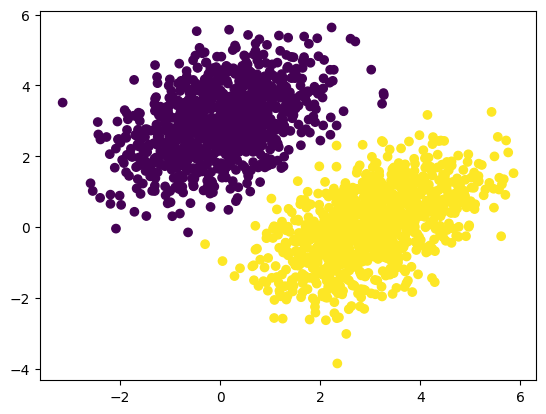

In [9]:
predictions = model(X)
plt.scatter(X[:,0], X[:,1], c=predictions[:,0]>0.5)
plt.show()

In [10]:
x = np.linspace(-1,4, 100)
y = - W[0] / W[1] * x + (0.5-b) / 2[1]

<>:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
/var/folders/16/kd90d1b55jb0hsbll9zf48vc0000gn/T/ipykernel_44676/2058244783.py:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  y = - W[0] / W[1] * x + (0.5-b) / 2[1]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

# **ATONOMY OF NEURAL NETWORK:**

## LAYERS: THE BUILDING BLOCK OF DEEP LEARNING

### **THE BASE LAYERS CLASS IN KERAS**

In [8]:
import torch.nn as nn
import torch

class SimpleDense(nn.Module):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation
        self.W = None
        self.b = None
    def build(self, input_shape):
        self.W = nn.Parameter(torch.rand(input_shape, self.units)*0.05)
        self.b = nn.Parameter(torch.zeros(self.units))
    def forword(self, inputs):
        if self.W is None:
            self.build(inputs.shape[-1])
        y = inputs @ self.W + self.b
        if self.activation:
            y = self.activation(y)


### **AUTOMATIC SHAPE INFERENCE: BUILDING LAYERS ON THE FLY**

In [2]:
import torch
import torch.nn as nn
layer = nn.LazyLinear(32)

In [4]:
model = nn.Sequential(
    nn.Linear(784,32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.ReLU()
)

It would be even worse if the rules used by a layer to produce its output shape ar complex, For instance, what if our layer returned output of shape(batch, input_size * 2 if input_size%2==0 else input_size * 3)

In [10]:
import torch.nn.functional as F
model = nn.Sequential(
    SimpleDense(32, activation=F.relu),
    SimpleDense(64, activation=F.relu),
    SimpleDense(32, activation=F.relu),
    SimpleDense(10, activation= lambda x: F.softmax(x, dim=1))
)

### **FROM LAYERS TO MODELS**

* TWO-BRANCH NETWORKS
* MULTIHEAD NETWORKS
* PRESIDUAL CONNECTIONS

### **THE "*COMPILE*" STEP: CONFIGURING THE LEARNING PROCESS**

* **Loss Function**
* **Optimizer**
* **Metrics**

In [50]:
import torch
import torch.nn as nn

In [76]:
model = nn.Sequential(
    nn.LazyLinear(1)
)

# ---this section work like tensorflow model.compile(...)---

_optimeser_ = torch.optim.RMSprop(model.parameters(), lr = 0.001)
_loss_ = nn.MSELoss()

# Torch doesn't have accuracy matrics unlike tnsorflow so we have to do manually
def accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim = 1)
    return (preds == y_true).float().mean()
# but also is available in trochmetircs but have to install first
from torchmetrics.classification import Accuracy
_accuracy_ = Accuracy(task='multiclass',num_classes=2)


**OPTIMIZDERS:**
* SGD (with or without momentum)
* RMSprop
* Adam
* Adagrad
* Etc

**LOSSESS:**
* CategorcalCrossentropy - nn.CrossEntropyLoss() 
* SparseCategorcalCrossentropy - also same
* BinaryCrossentorpy - nn.BCELoss()
* MeanSquaredError - nn.MSELoss()
* KLDivergence - nn.KLDivLoss()
* ConsineSimilarity - nn.CosineEmbeddingLoss() or F.cosine_similarity() (functional API)

**METRICS:** *(have to use torchmetrics module)*
* CategoricalAccuracy
* SparseCategoricalAccuracy
* Binary accuracy
* AUC
* Precision
* Recall
* Etc

we will go detail on later

### **UNDERSTANDING THE ***fit()*** MTHOD OF TENSORFLOW**

In [205]:
import numpy as np
import torch

n = 1000
neg = np.random.multivariate_normal([0,3], [[1,0.5],[0.5,1]], size=n)
pos = np.random.multivariate_normal([3,0], [[1,0.5],[0.5,1]], size=n)

X_np =  np.vstack([neg,pos]).astype(np.float32)
y_np = np.vstack([np.zeros((n,1), np.float32),
                  np.ones((n,1), np.float32)])
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()

In [204]:
X.shape, y.shape

(torch.Size([2000, 2]), torch.Size([8, 1]))

In [206]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [141]:


for epoch in range(5):
    model.train()
    current_loss, current_accuracy, n = 0.0, 0.0, 0
    for x, y in loader:
        _optimeser_.zero_grad()
        y_pred = model(x)
        loss = _loss_(y_pred, y)
        loss.backward()
        _optimeser_.step()
        b = x.size(0)
        current_loss += loss.item() * b
        current_accuracy += _accuracy_(y_pred, y).item() * b
        n+=b

    print(f"Epoch {epoch+1}: loss={current_loss/n:.4f}, acc={current_accuracy/n:.4f}")

        

/Users/tanvir15/Documents/12 month ai challange/deep_learning/.venv_tf/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: The `preds` and `target` should have the same shape, got `preds` with shape=torch.Size([32, 2]) and `target` with shape=torch.Size([32, 1]).

### **TRAIN AND TEST DATA FOR MONITORING LOSS AND MECTRICS ON VALIDATION**

In [207]:
import torch
import torch.nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader, Subset
perm = torch.randperm(len(X))
val_count = int(0.3 * len(X))
val_idx = perm[:val_count]
train_idx = perm[val_count:]

ds = TensorDataset(X,y)
train_loader = DataLoader(Subset(ds, train_idx), batch_size=16, shuffle=True) #train data
val_loader = DataLoader(Subset(ds, val_idx), batch_size=16, shuffle=True) #Test data

In [248]:
# --- Creating the model ---
model = nn.Sequential(
    # nn.Linear(2,10),
    # nn.ReLU(),
    # nn.Dropout(0.5),
    # nn.ReLU(),
    # nn.ReLU(),
    # nn.ReLU(),
    # nn.Linear(10,1)
    nn.Linear(2,1)
)
criterion = nn.MSELoss()
optimzer = optim.RMSprop(model.parameters(), lr=0.001)

def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

In [249]:
#---taining----
for epoch in range(10):
    model.train()
    train_loss, train_acc = 0.0, 0.0
    n_train = 0
    for x, y in train_loader:
        optimzer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimzer.step()

        b=x.size(0)
        train_loss += loss.item() * b
        train_acc += accuracy(y_pred, y).item() * b
        n_train += b
    print(f"Epoch {epoch+1}/25 | train_loss: {train_loss/n_train:.4f} train_acc: {train_acc/n_train:.4f}")

Epoch 1/25 | train_loss: 5.0728 train_acc: 0.4921
Epoch 2/25 | train_loss: 3.6131 train_acc: 0.4921
Epoch 3/25 | train_loss: 2.6896 train_acc: 0.4921
Epoch 4/25 | train_loss: 1.9813 train_acc: 0.4921
Epoch 5/25 | train_loss: 1.4134 train_acc: 0.4921
Epoch 6/25 | train_loss: 0.9639 train_acc: 0.4921
Epoch 7/25 | train_loss: 0.6216 train_acc: 0.4921
Epoch 8/25 | train_loss: 0.3717 train_acc: 0.4921
Epoch 9/25 | train_loss: 0.2045 train_acc: 0.4921
Epoch 10/25 | train_loss: 0.1057 train_acc: 0.4921


In [251]:
#---Validation---
for epoch in range(5):
    model.eval()
    val_loss, val_acc, n_val= 0.0, 0.0, 0
    with torch.no_grad():
        for x, y in val_loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            b = x.size(0)
            val_loss += loss.item() * b
            val_acc += (y_pred.argmax(dim=1) == y).float().mean()
            n_val += b
    print(f"Epoch {epoch+1}/5 | "
          f"val_loss={val_loss/n_val:.4f} val_acc={val_acc/n_val:.4f}")      

Epoch 1/5 | val_loss=0.0689 val_acc=0.0329
Epoch 2/5 | val_loss=0.0689 val_acc=0.0331
Epoch 3/5 | val_loss=0.0689 val_acc=0.0327
Epoch 4/5 | val_loss=0.0689 val_acc=0.0330
Epoch 5/5 | val_loss=0.0689 val_acc=0.0329


### **INFERENCE: USING A MODEL AFTER TRAININNG**

In [262]:
model.eval()
with torch.no_grad():
    x = X[0].unsqueeze(0)
    y_pred = model(x)
    print(y_pred)

tensor([[-0.1357]])


In [261]:
model(X[0])

tensor([-0.1357], grad_fn=<ViewBackward0>)

In [246]:
y[0]

tensor([0.])

BATCH PREDICTION

In [259]:
def predict(model, loader):
    model.eval()
    outs = []
    with torch.no_grad():
        for x in loader:
            if isinstance(x, (list, tuple)): x = x[0] # if dataset returns (x,y)
            outs.append(model(x))
    return torch.cat(outs)

In [260]:
predict(model=model, loader=val_loader)

tensor([[ 0.0978],
        [ 0.5473],
        [ 0.0906],
        [-0.2055],
        [ 0.1779],
        [-0.0057],
        [ 0.6192],
        [ 0.5675],
        [ 0.1700],
        [ 0.6384],
        [ 0.2372],
        [ 0.2913],
        [ 0.1098],
        [-0.1449],
        [ 0.0670],
        [ 0.5388],
        [-0.2984],
        [-0.0348],
        [ 0.7747],
        [ 0.6487],
        [ 0.6102],
        [ 0.5413],
        [ 0.0437],
        [ 0.6976],
        [ 0.1039],
        [ 0.0791],
        [-0.0872],
        [ 0.6899],
        [-0.1312],
        [ 0.2206],
        [ 0.3229],
        [ 0.0578],
        [-0.1887],
        [-0.1357],
        [ 0.0311],
        [ 0.8581],
        [ 0.0179],
        [ 0.4307],
        [ 0.6497],
        [ 0.6160],
        [-0.0126],
        [ 0.0916],
        [ 0.1079],
        [ 0.0768],
        [ 0.0125],
        [ 0.1554],
        [ 0.6981],
        [ 0.1040],
        [-0.0385],
        [ 0.2215],
        [ 0.7237],
        [ 0.6106],
        [ 0.

In [263]:
predict(model=model, loader=train_loader)

tensor([[0.3844],
        [0.0969],
        [0.5526],
        ...,
        [0.5925],
        [0.1438],
        [0.4716]])